In [15]:
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap

In [2]:
# Load data for all 3 years
data_2020 = pd.read_csv('../data/img_scout_dfs/2020/INC_coreg_skysat_scout_2020.csv')
data_2021 = pd.read_csv('../data/img_scout_dfs/2021/INC_skysat_scout_2021.csv')
data_2022 = pd.read_csv('../data/img_scout_dfs/2022/INC_skysat_scout_2022.csv')

df_list = [data_2020, data_2021, data_2022]

In [6]:
def add_vis(df):
    df['ndvi']= (df['nir']-df['red'])/(df['nir']+df['red'])
    df['evi']= 2.5*(df['nir']-df['red'])/(df['nir']+6*df['red']-7.5*df['blue']+1)
    df['savi']= 1.5*(df['nir']-df['red'])/(df['nir']+df['red']+0.5)
    #df['sr']= df['nir']/df['red']
    #df['msr']= ((df['nir']/df['red'])-1)/(np.sqrt((df['nir']/df['red'])+1))
    #df['dvi']= df['nir']-df['red']
    #df['nirv']= df['ndvi']*df['nir']
    #df['gcc']=df['green']/(df['green']+df['red']+df['blue'])
    #df['tvi']=0.5*(120*(df['nir']-df['green'])-200*(df['red']-df['green']))
    df['arvi']=(df['nir']-(2*df['red']-df['blue']))/(df['nir']+(2*df['red']-df['blue']))
    df['gri']=df['green']/df['red']
    
    return df

In [7]:
# Add columns for VIs, GDM incidence, and GDM severity to each df 
for d in df_list:
    add_vis(d)
    
    d['GDM_sev']='low'
    d.loc[d['DM_severity'] > 10, 'GDM_sev'] = 'high'
    
    d['GDM_inc']='low'
    d.loc[d['DM_inc'] > 25, 'GDM_inc'] = 'high'

In [10]:
data_2020.columns
#data_2020[['blue', 'green', 'red', 'nir']]

Index(['acquired', 'plot', 'blue', 'green', 'red', 'nir', 'row', 'panel',
       'Date', 'Treatment', 'Block', 'PM_severity', 'DM_severity', 'total_dis',
       'geometry', 'centroid', 'PM_inc', 'DM_inc', 'ndvi', 'evi', 'savi',
       'arvi', 'gri', 'GDM_sev', 'GDM_inc'],
      dtype='object')

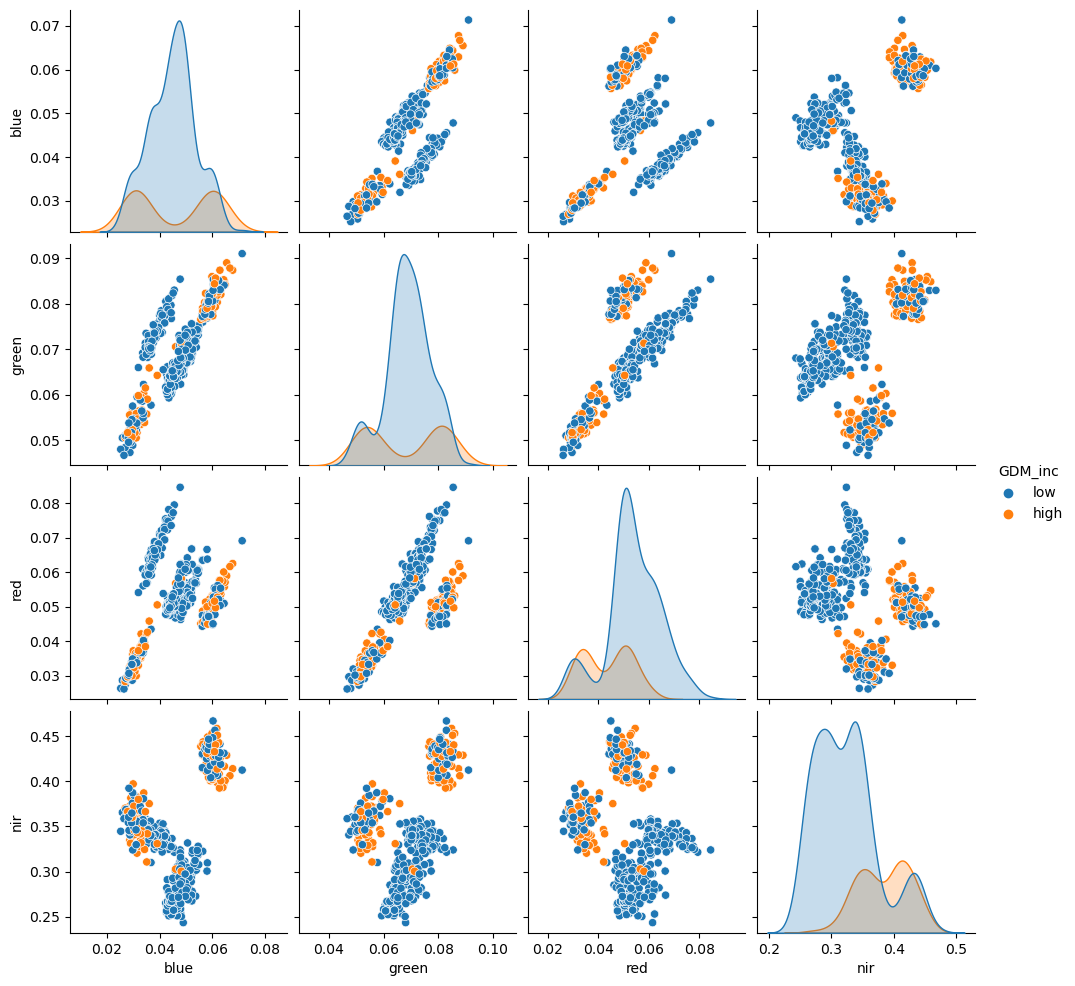

In [13]:
# Try with one year at a time

sns.pairplot(data_2020[['blue', 'green', 'red', 'nir', 'GDM_sev', 'GDM_inc']], hue='GDM_inc');

In [69]:
# Create UMAP reducer to reduce dimensionality of dataset

reducer = umap.UMAP()

# Filter to just features and scale 

feature_data = data_2020[
    [
#       'blue', 'green', 'red', 'nir',
        'ndvi', 'evi', 'savi', 'arvi', 'gri'
    ]
].values
scaled_feature_data = StandardScaler().fit_transform(feature_data)

In [70]:
# Fit the UMAP reducer to scaled feature data
# This embeds the features as a 2D array

embedding = reducer.fit_transform(scaled_feature_data)
embedding.shape

(499, 2)

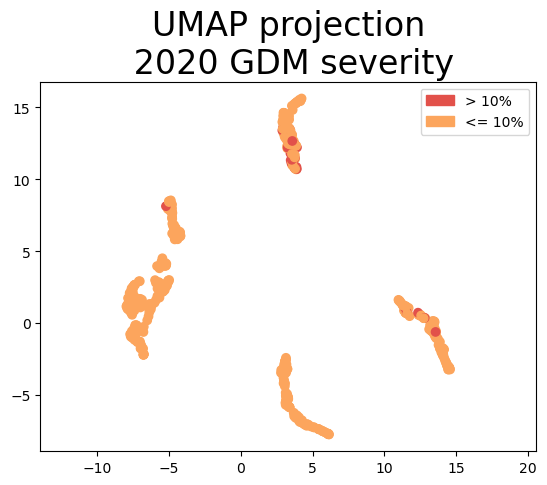

In [71]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette('Spectral')[x] for x in data_2020.GDM_sev.map({"high":0, "low":1})])

healthy_patch = mpatches.Patch(color='#e2514a', label='> 10%')
disease_patch = mpatches.Patch(color='#fca55d', label='<= 10%')

plt.legend(handles=[healthy_patch, disease_patch])

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection\n 2020 GDM severity', fontsize=24);

In [72]:
data_2020.Date.unique()

array(['2020-06-18', '2020-06-25', '2020-07-09', '2020-08-06',
       '2020-08-13'], dtype=object)

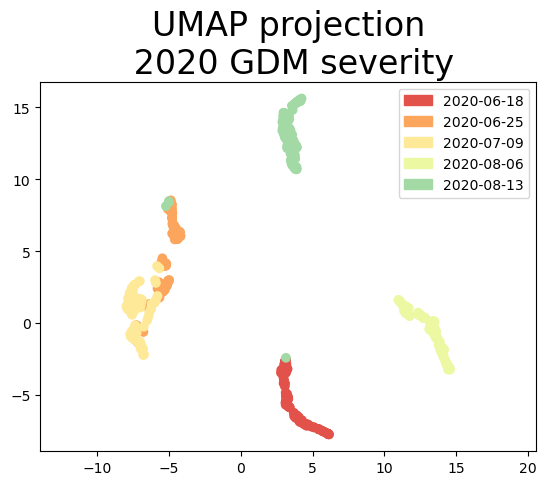

In [73]:
# Color by date
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette('Spectral')[x] for x in data_2020.Date.map({"2020-06-18":0, "2020-06-25":1,
                                                           '2020-07-09':2,'2020-08-06':3,
                                                          '2020-08-13':4})])
patch_1 = mpatches.Patch(color=pal[0], label='2020-06-18')
patch_2 = mpatches.Patch(color=pal[1], label='2020-06-25')
patch_3 = mpatches.Patch(color=pal[2], label='2020-07-09')
patch_4 = mpatches.Patch(color=pal[3], label='2020-08-06')
patch_5 = mpatches.Patch(color=pal[4], label='2020-08-13')


plt.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection\n 2020 GDM severity', fontsize=24);

In [74]:
print(sns.color_palette("Spectral").as_hex())

['#e2514a', '#fca55d', '#fee999', '#edf8a3', '#a2d9a4', '#47a0b3']


In [75]:
pal = sns.color_palette("Spectral").as_hex()

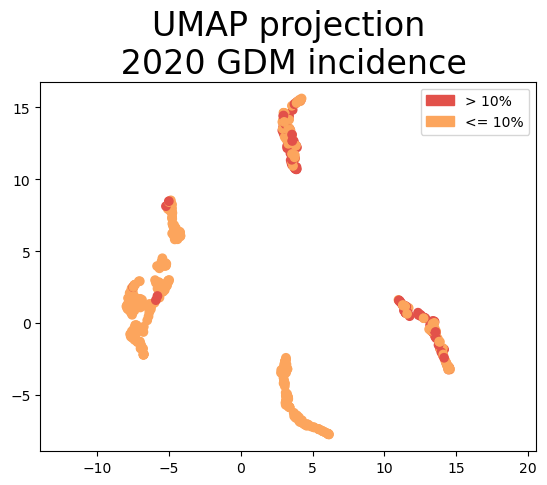

In [76]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette('Spectral')[x] for x in data_2020.GDM_inc.map({"high":0, "low":1})])

import matplotlib.patches as mpatches 

healthy_patch = mpatches.Patch(color='#e2514a', label='> 10%')
disease_patch = mpatches.Patch(color='#fca55d', label='<= 10%')

plt.legend(handles=[healthy_patch, disease_patch])

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection\n 2020 GDM incidence', fontsize=24);

In [85]:
# Functionalize

def umap_plt(df, features, label, leg_labels):
    reducer = umap.UMAP()
    
    feature_data = df[features].values
    
    scaled_feature_data = StandardScaler().fit_transform(feature_data)
    
    embedding = reducer.fit_transform(scaled_feature_data)
    
    plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette('Spectral')[x] for x in df[label].map({df[label].unique()[0]:0, 
                                                                        df[label].unique()[1]:1})])
    
    healthy_patch = mpatches.Patch(color='#e2514a', label=df[label].unique()[0])
    disease_patch = mpatches.Patch(color='#fca55d', label=df[label].unique()[1])
    
    plt.legend(handles=[healthy_patch, disease_patch])
    
    plt.gca().set_aspect('equal', 'datalim')
    
    plt.title('UMAP projection\n {}'.format(label), fontsize=24);
    
    return plt.show()

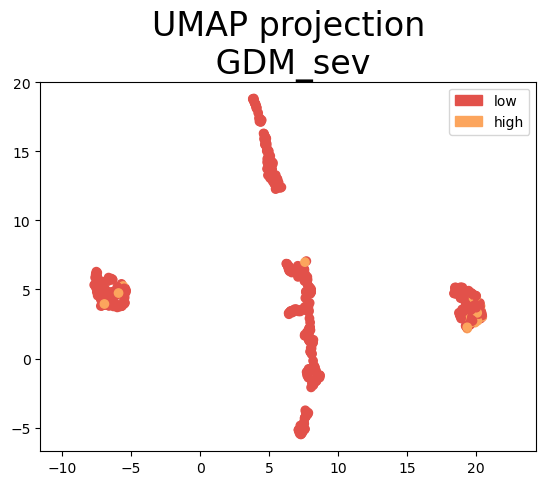

In [87]:
umap_plt(data_2020, ['blue', 'green', 'red', 'nir'], 
        'GDM_sev', ['low', 'high'])

In [89]:
daily_dfs=[]
for date in data_2020.Date.unique():
    daily_data = data_2020[data_2020['Date']==date]
    daily_dfs.append(daily_data)
len(daily_dfs)

5

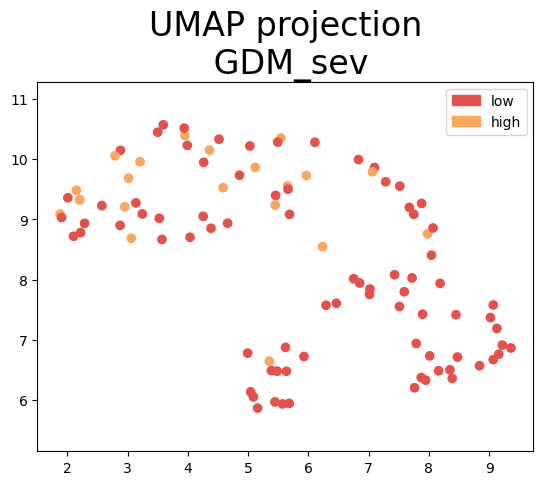

In [94]:
umap_plt(daily_dfs[4], ['blue', 'green', 'red', 'nir'], 
        'GDM_sev', ['low', 'high'])

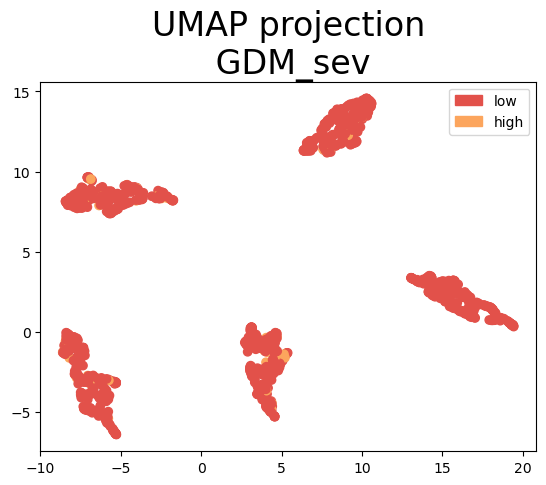

In [97]:
umap_plt(data_2021, ['blue', 'green', 'red', 'nir', 'ndvi', 'evi'], 
        'GDM_sev', ['low', 'high'])

In [98]:
daily_dfs_21=[]
for date in data_2021.Date.unique():
    daily_data = data_2021[data_2021['Date']==date]
    daily_dfs_21.append(daily_data)
len(daily_dfs_21)

5

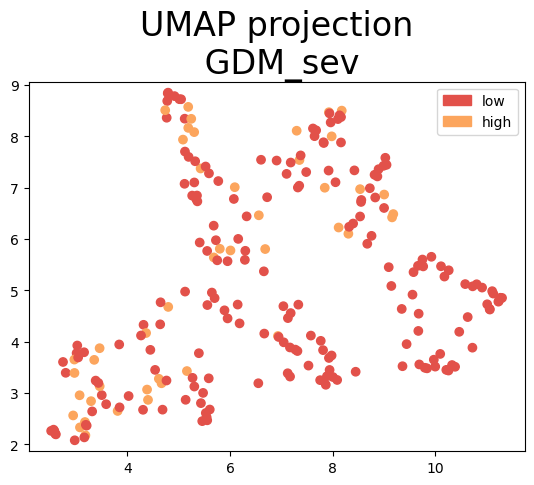

In [102]:
umap_plt(daily_dfs_21[4], ['blue', 'green', 'red', 'nir', 'ndvi', 'evi'], 
        'GDM_sev', ['low', 'high'])

In [113]:
umap_plt(daily_dfs_21[2], [
    #'blue', 'green', 'red', 'nir', 
    'ndvi', 'gri','savi','arvi','evi'], 
        'GDM_inc', ['low', 'high'])

IndexError: index 1 is out of bounds for axis 0 with size 1